<h1>DA311, Machine Learning Laboratory</h1>
<h1>Course Project</h1>
<h1>Histopathological Image Analysis for Breast Cancer Detection using Cubic SVM</h1>

<h3>Name: Billa Cherish</h3>
<h3>Roll No: 230150007</h3>

<h3>Importing the required libraries</h3>

In [1]:
import numpy as np
import pandas as pd
import os
import time
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2
from glob import glob
from skimage import io, color
from skimage.util import img_as_ubyte
from scipy import ndimage

# Feature Extraction
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
from scipy.signal import convolve2d

# For Machine Learning Classifiers
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, ParameterGrid, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

<h3>Loading the dataset</h3>


In [2]:
BENIGN_PATH = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign'
MALIGNANT_PATH = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant'

# Function for extracting the magnification value from the image path
def extract_magnification(filepath):
    if '40X' in filepath:
        return '40X'
    elif '100X' in filepath:
        return '100X'
    elif '200X' in filepath:
        return '200X'
    elif '400X' in filepath:
        return '400X'

<h4>Benign (Non-cancerous): Label = 0 </h4>
<h4>Malignant (Cancerous): Label = 1</h4>

In [3]:
dataset = []

# Finding the image paths
benign_images = glob(os.path.join(BENIGN_PATH, '**', '*.png'), recursive=True)
malignant_images = glob(os.path.join(MALIGNANT_PATH, '**', '*.png'), recursive=True)

# Storing the image paths
for img_path in benign_images:
    dataset.append({
        'Path': img_path,
        'Label': 0,
        'Magnification': extract_magnification(img_path),
        'Type': 'Benign'
    })

for img_path in malignant_images:
    dataset.append({
        'Path': img_path,
        'Label': 1,
        'Magnification': extract_magnification(img_path),
        'Type': 'Malignant'
    })


dataset_df = pd.DataFrame(dataset)

<h4>An Example Image</h4>

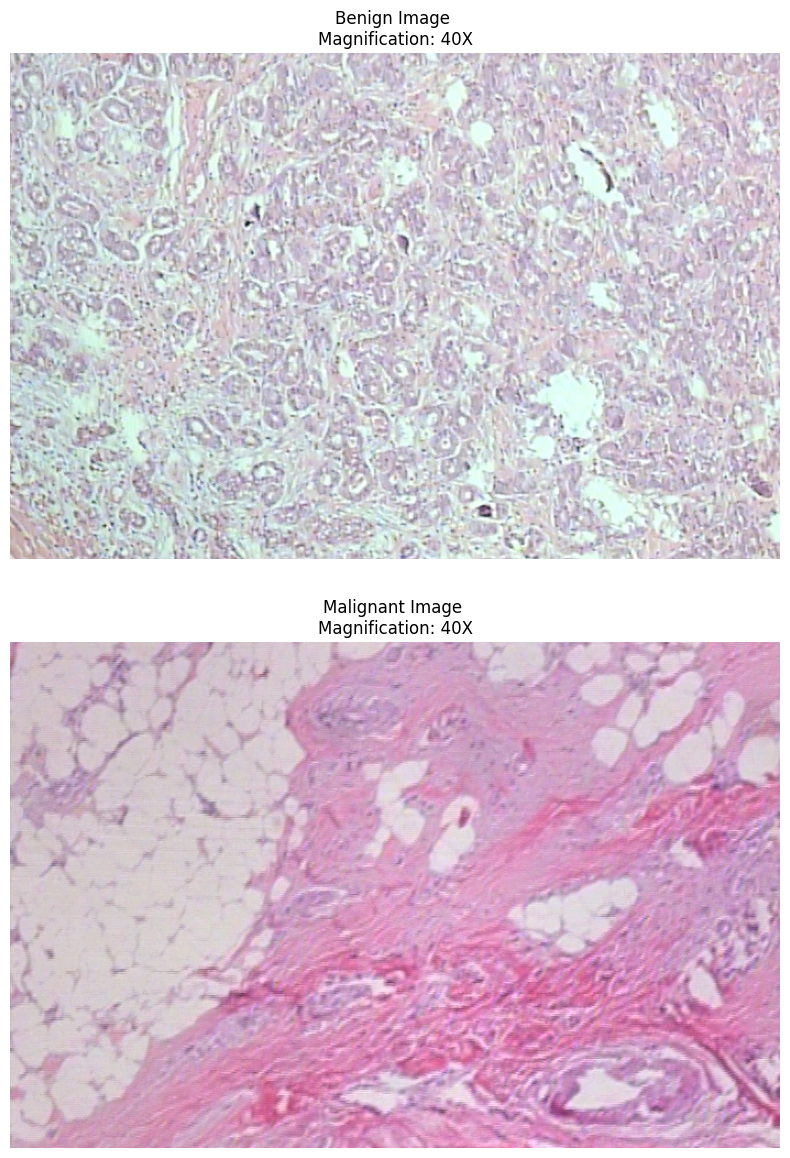

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Benign Image
benign_img_path = benign_images[40]
benign_img = cv2.imread(benign_img_path)
benign_img_rgb = cv2.cvtColor(benign_img, cv2.COLOR_BGR2RGB)
benign_mag = extract_magnification(benign_img_path)

axes[0].imshow(benign_img_rgb)
axes[0].set_title(f"Benign Image \nMagnification: {benign_mag}")
axes[0].axis('off')

# Malignant Image
malignant_img_path = malignant_images[40]
malignant_img = cv2.imread(malignant_img_path)
malignant_img_rgb = cv2.cvtColor(malignant_img, cv2.COLOR_BGR2RGB)
malignant_mag = extract_magnification(malignant_img_path)

axes[1].imshow(malignant_img_rgb)
axes[1].set_title(f"Malignant Image \nMagnification: {malignant_mag}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

<h4>Summary of the Dataset</h4>

In [5]:
# Count by Magnification and Type
summary = dataset_df.groupby(['Magnification', 'Type']).size().unstack(fill_value=0)

# Summation over a column
summary['Total'] = summary.sum(axis=1)

# Summation over a row
summary.loc['Total images'] = summary.sum(axis=0)

summary.columns.name = None

# Reorder columns for display
summary = summary[['Benign', 'Malignant', 'Total']]

print(summary)

               Benign  Malignant  Total
Magnification                          
100X              644       1437   2081
200X              623       1390   2013
400X              588       1232   1820
40X               625       1370   1995
Total images     2480       5429   7909


<h3>Image Preprocessing</h3>

<h4>Converting RGB image to Grey-scale</h4>

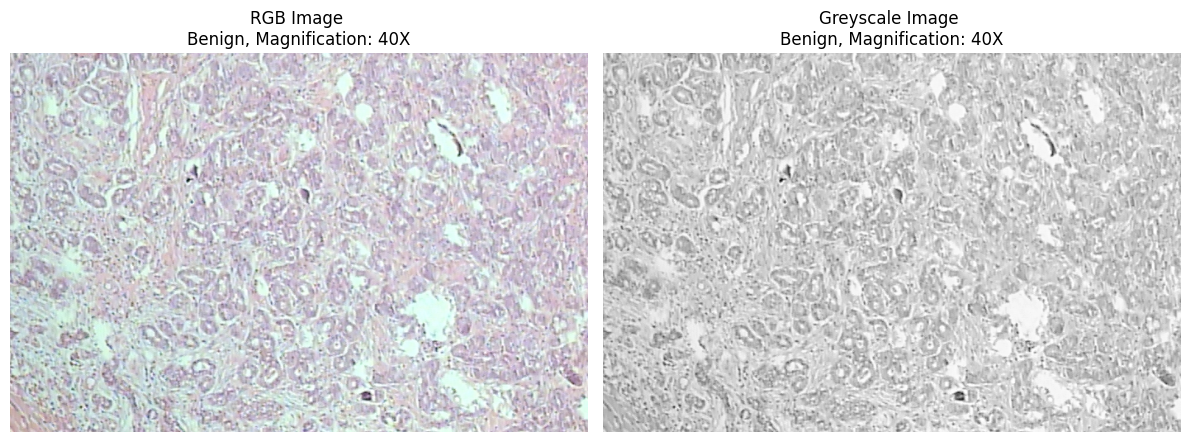

In [6]:
# RGB to Grayscale: Grey = 0.2989*R + 0.5870*G + 0.1140*B
def rgb_to_greyscale(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_grey = 0.2989 * image_rgb[:, :, 0] + 0.58970 * image_rgb[:, :, 1] + 0.1140 * image_rgb[:, :, 2]
    return image_grey.astype(np.uint8)


# Example: Benign Image
img_path = benign_images[40]
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = rgb_to_greyscale(img_path)

magnification = extract_magnification(img_path)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_rgb)
axes[0].set_title(f"RGB Image \nBenign, Magnification: {magnification}")
axes[0].axis('off')

axes[1].imshow(img_grey, cmap='gray')
axes[1].set_title(f"Greyscale Image \nBenign, Magnification: {magnification}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

<h1>Feature Extraction</h1>

<h3>Gray-level Co-occurrence Matrix</h3>

In [7]:
def extract_glcm_features(gray_image):
    # Determining the Offset
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Calculating the GLCM, one in each direction
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, 
                       levels=256, symmetric=True, normed=True)
    
    # Extract 12 GLCM features (3 from each GLCM)
    features = []
    for prop in ['contrast', 'homogeneity', 'energy']:
        prop_values = graycoprops(glcm, prop)
        features.extend(prop_values[0])
    
    return np.array(features)

<h3>Local Binary Pattern</h3>

In [8]:
def extract_lbp_features(gray_image):
    # Finding the local binary patterns for every pixel
    lbp = local_binary_pattern(gray_image, 8, 1, method='uniform')
    n_bins = 10  # For uniform LBP: 8 + 2

    # Calculating the Histogram
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-7)
    
    features = np.tile(hist, 6)[:60]  # Use tiling to get 60 features
    
    return np.array(features)

<h3>Law's Texture Energy</h3>

In [9]:
def extract_lte_features(gray_image):
    # 1x5 kernels
    L5 = np.array([1, 4, 6, 4, 1], dtype=float)   # Level
    E5 = np.array([-1, -2, 0, 2, 1], dtype=float) # Edge
    S5 = np.array([-1, 0, 2, 0, -1], dtype=float) # Spot
    R5 = np.array([1, -4, 6, -4, 1], dtype=float) # Ripple

    kernels_1d = [L5, E5, S5, R5]
    kernel_names = ['L5', 'E5', 'S5', 'R5']

    # 5x5 kernels
    kernels_2d = {}
    for i, k1 in enumerate(kernels_1d):
        for j, k2 in enumerate(kernels_1d):
            name = kernel_names[i] + kernel_names[j]
            kernels_2d[name] = np.outer(k1, k2)

    # Illumination normalization by subtracting local mean (15x15 box filter)
    image = gray_image.astype(np.float32)
    local_mean = convolve2d(image, np.ones((15, 15)) / 225, mode='same', boundary='symm')
    image = image - local_mean

    # For each kernel, convolve and extract mean absolute response as feature
    features = []
    for name in kernels_2d:
        filtered = convolve2d(image, kernels_2d[name], mode='same', boundary='symm')
        # Mean Energy
        mean_energy = np.mean(np.abs(filtered))
        features.append(mean_energy)

    return np.array(features, dtype=np.float32)


<h3>Haralick Features</h3>

In [10]:
def extract_haralick_features(gray_image):
    # Defining the offset
    distances=[1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    # Quantizing the Image, [0 to 255] -> [0 to 31]
    image_quantized = (gray_image // 8).astype(np.uint8)

    # Calculating the GLCM, one in each direction
    glcm = graycomatrix(image_quantized, distances=distances, angles=angles, 
                       levels=32, symmetric=True, normed=True)
    
    # Extracting 3 features form each GLCM
    features = []
    for prop in ['correlation', 'dissimilarity', 'ASM']:
        prop_values = graycoprops(glcm, prop)
        features.extend(prop_values[0])
    
    return np.array(features)

<h3>A Function to Extract all the 100 features</h3>

In [11]:
def extract_all_features(gray_image):
    glcm_feat = extract_glcm_features(gray_image)      # F1-F12: 12
    lbp_feat = extract_lbp_features(gray_image)        # F13-F72: 60
    lte_feat = extract_lte_features(gray_image)        # F73-F88: 16
    htf_feat = extract_haralick_features(gray_image)   # F89-F100: 12
    
    return np.concatenate([glcm_feat, lbp_feat, lte_feat, htf_feat])

<h4>An Example of feature extraction</h4>

In [12]:
img_test = rgb_to_greyscale(benign_images[0])
extract_all_features(img_test)

array([9.09439323e+01, 1.75549197e+02, 1.03313265e+02, 1.61201922e+02,
       2.26868416e-01, 1.81930364e-01, 2.16248842e-01, 1.87347871e-01,
       3.74595227e-02, 3.30370142e-02, 3.48020302e-02, 3.32904853e-02,
       4.85000000e-02, 6.73881988e-02, 5.81521739e-02, 1.35791925e-01,
       1.82475155e-01, 1.48854037e-01, 7.17950311e-02, 7.13074534e-02,
       8.62298137e-02, 1.29506211e-01, 4.85000000e-02, 6.73881988e-02,
       5.81521739e-02, 1.35791925e-01, 1.82475155e-01, 1.48854037e-01,
       7.17950311e-02, 7.13074534e-02, 8.62298137e-02, 1.29506211e-01,
       4.85000000e-02, 6.73881988e-02, 5.81521739e-02, 1.35791925e-01,
       1.82475155e-01, 1.48854037e-01, 7.17950311e-02, 7.13074534e-02,
       8.62298137e-02, 1.29506211e-01, 4.85000000e-02, 6.73881988e-02,
       5.81521739e-02, 1.35791925e-01, 1.82475155e-01, 1.48854037e-01,
       7.17950311e-02, 7.13074534e-02, 8.62298137e-02, 1.29506211e-01,
       4.85000000e-02, 6.73881988e-02, 5.81521739e-02, 1.35791925e-01,
      

<h3>Extracting features from the entire dataset</h3>

In [13]:
def extract_features_batch(df, magnification, samples_per_class):
    print(f"\nProcessing {magnification}")

    # Selecting the images with the corresponding magnification factor
    mag_df = df[df['Magnification'] == magnification].reset_index(drop=True)
    benign_df = mag_df[mag_df['Label'] == 0].sample(n=min(samples_per_class, len(mag_df[mag_df['Label'] == 0])), random_state=42)
    malignant_df = mag_df[mag_df['Label'] == 1].sample(n=min(samples_per_class, len(mag_df[mag_df['Label'] == 1])), random_state=42)
    
    selected_df = pd.concat([benign_df, malignant_df]).reset_index(drop=True)
    print(f"{len(selected_df)} images ({len(benign_df)} benign + {len(malignant_df)} malignant)")
    
    X, y = [], []
    
    for idx, row in selected_df.iterrows():
        if (idx + 1) % 50 == 0:
            print(f"  Progress: {idx+1}/{len(selected_df)}...")
        gray_img = rgb_to_greyscale(row['Path'])
        features = extract_all_features(gray_img)
        X.append(features)
        y.append(row['Label'])

    return np.array(X), np.array(y)

In [14]:
start_time = time.time()

datasets = {}
X_dict = {}
y_dict = {}
magnifications = ['40X', '100X', '200X', '400X']

for mag in magnifications:
    X, y = extract_features_batch(dataset_df, mag, samples_per_class=400)
    datasets[mag] = {'X': X, 'y': y}
    X_dict[mag] = X
    y_dict[mag] = y

elapsed = time.time() - start_time
print(f"Time taken: \n{elapsed/60:.1f} minutes")


Processing 40X
800 images (400 benign + 400 malignant)
  Progress: 50/800...
  Progress: 100/800...
  Progress: 150/800...
  Progress: 200/800...
  Progress: 250/800...
  Progress: 300/800...
  Progress: 350/800...
  Progress: 400/800...
  Progress: 450/800...
  Progress: 500/800...
  Progress: 550/800...
  Progress: 600/800...
  Progress: 650/800...
  Progress: 700/800...
  Progress: 750/800...
  Progress: 800/800...

Processing 100X
800 images (400 benign + 400 malignant)
  Progress: 50/800...
  Progress: 100/800...
  Progress: 150/800...
  Progress: 200/800...
  Progress: 250/800...
  Progress: 300/800...
  Progress: 350/800...
  Progress: 400/800...
  Progress: 450/800...
  Progress: 500/800...
  Progress: 550/800...
  Progress: 600/800...
  Progress: 650/800...
  Progress: 700/800...
  Progress: 750/800...
  Progress: 800/800...

Processing 200X
800 images (400 benign + 400 malignant)
  Progress: 50/800...
  Progress: 100/800...
  Progress: 150/800...
  Progress: 200/800...
  Pro

<h2>Cubic SVM</h2>

<h3>Hyperparameter Tuning</h3>

In [17]:
# Tuning on 40X magnification factor
X = X_dict['40X']
y = y_dict['40X']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

param_dist = {
    'C': [0.1, 1, 10, 100, 500],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'coef0': [0, 1, 10]
}

cubic_search = RandomizedSearchCV(
    SVC(kernel='poly', degree=3, class_weight='balanced', probability=True, random_state=42),
    param_distributions=param_dist,
    n_iter=25,           # 25 random combinations
    cv=7,                # 7-fold CV 
    scoring='accuracy',
    n_jobs=-1,           # Parallel computation
    random_state=42
)

cubic_search.fit(X_scaled, y)
print(f"Best params: {cubic_search.best_params_}")
print(f"Best accuracy: {cubic_search.best_score_:.4f}")

best_cubic_params = cubic_search.best_params_ 

Best params: {'gamma': 'auto', 'coef0': 10, 'C': 100}
Best accuracy: 0.8450


<h3>Fitting the Cubic SVM Classifier</h3>

In [18]:
def model_results_table_and_folds(model, X_dict, y_dict, name):
    magnification_order = ['40X', '100X', '200X', '400X']
    table = []
    fold_accuracies_dict = {}
    scaler = StandardScaler()

    for mag in magnification_order:
        X, y = X_dict[mag], y_dict[mag]
        X_scaled = scaler.fit_transform(X)
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        scores = {'P': [], 'R': [], 'A': [], 'F1': [], 'Specificity': []}
        fold_accuracies = []
        print(f"Processing {mag} - Total folds: {skf.get_n_splits()}")
        
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_scaled, y)):
            model.fit(X_scaled[train_idx], y[train_idx])
            y_pred = model.predict(X_scaled[test_idx])
            
            tn, fp, fn, tp = confusion_matrix(y[test_idx], y_pred).ravel()
            
            scores['P'].append(precision_score(y[test_idx], y_pred, zero_division=0))
            scores['R'].append(recall_score(y[test_idx], y_pred, zero_division=0))
            acc = accuracy_score(y[test_idx], y_pred)
            scores['A'].append(acc)
            scores['F1'].append(f1_score(y[test_idx], y_pred, zero_division=0))
            scores['Specificity'].append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            
            fold_accuracies.append(acc)
            #print(f"        Mean accuracy: {np.mean(fold_accuracies):.4f}")
            
        fold_accuracies_dict[mag] = fold_accuracies
        
        table.append([
            mag,
            np.mean(scores['P']),
            np.mean(scores['R']),
            np.mean(scores['A']),
            np.mean(scores['F1']),
            np.mean(scores['Specificity'])
        ])
        
    df = pd.DataFrame(table, columns=['Magnification factor', 'P', 'R', 'A', 'F1', 'Specificity'])
    print(f"\nResults for {name}:\n")
    print(df.to_markdown(index=False))
    
    return df, fold_accuracies_dict       


cubic_model_tuned = SVC(
    kernel='poly', degree=3, class_weight='balanced', random_state=4, probability=True,
    C=best_cubic_params['C'], gamma=best_cubic_params['gamma'], coef0=best_cubic_params['coef0']
)

df_cubic, cubic_fold_accuracies = model_results_table_and_folds(cubic_model_tuned, X_dict, y_dict, "Cubic SVM (Tuned)")

Processing 40X - Total folds: 10
Processing 100X - Total folds: 10
Processing 200X - Total folds: 10
Processing 400X - Total folds: 10

Results for Cubic SVM (Tuned):

| Magnification factor   |        P |      R |       A |       F1 |   Specificity |
|:-----------------------|---------:|-------:|--------:|---------:|--------------:|
| 40X                    | 0.845721 | 0.8425 | 0.84375 | 0.842995 |        0.845  |
| 100X                   | 0.844015 | 0.8425 | 0.8425  | 0.842061 |        0.8425 |
| 200X                   | 0.781204 | 0.78   | 0.77875 | 0.778196 |        0.7775 |
| 400X                   | 0.781901 | 0.77   | 0.7775  | 0.775256 |        0.785  |


<h3>Evaluation Metrics vs Magnification Factor</h3>

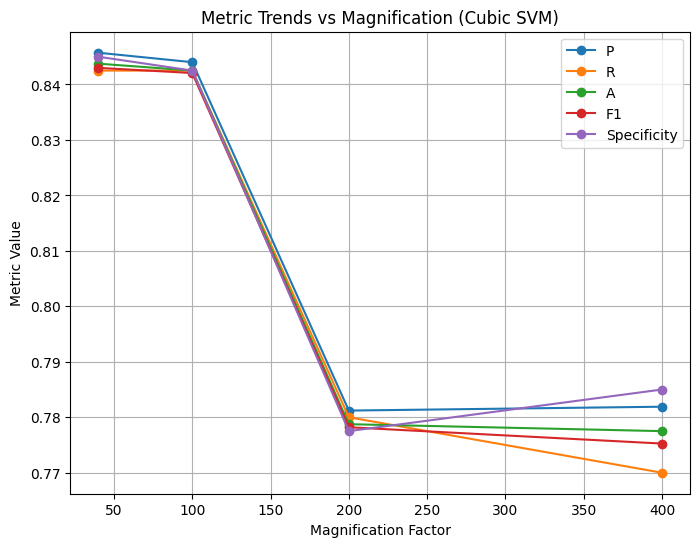

In [19]:
metrics_to_plot = ['P', 'R', 'A', 'F1', 'Specificity']
mag_labels = [int(mag[:-1]) for mag in df_cubic['Magnification factor']]
plt.figure(figsize=(8,6))
for metric in metrics_to_plot:
    plt.plot(mag_labels, df_cubic[metric], marker='o', label=metric)
plt.xlabel('Magnification Factor')
plt.ylabel('Metric Value')
plt.title('Metric Trends vs Magnification (Cubic SVM)')
plt.legend()
plt.grid(True)
plt.show()

<h3>ROC Curve</h3>

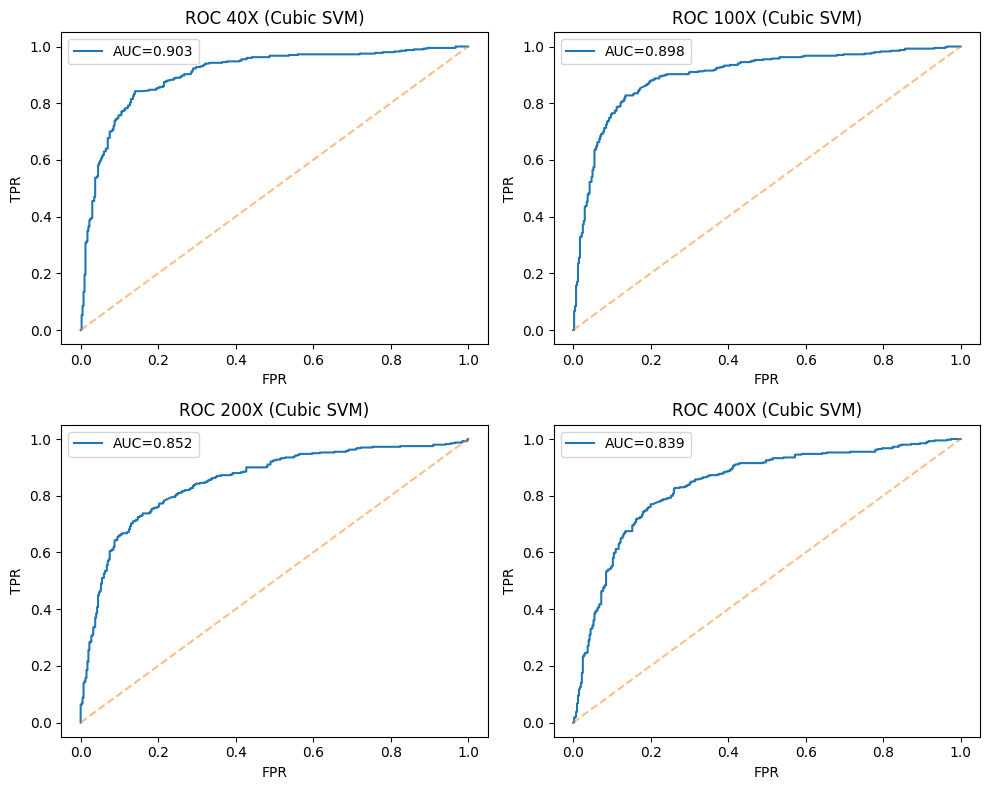

In [20]:
auc_dict_cubic = {}

plt.figure(figsize=(10,8))

for idx, mag in enumerate(['40X','100X','200X','400X']):
    X, y = X_dict[mag], y_dict[mag]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_true_all, y_score_all = [], []
    
    for train_idx, test_idx in skf.split(X_scaled, y):
        cubic_model_tuned.fit(X_scaled[train_idx], y[train_idx])
        
        y_score = (cubic_model_tuned.predict_proba(X_scaled[test_idx])[:, 1]
                   if hasattr(cubic_model_tuned, "predict_proba")
                   else cubic_model_tuned.decision_function(X_scaled[test_idx]))
        
        y_true_all.extend(y[test_idx])
        y_score_all.extend(y_score)
        
    fpr, tpr, _ = roc_curve(y_true_all, y_score_all)
    auc_value = roc_auc_score(y_true_all, y_score_all)
    auc_dict_cubic[mag] = auc_value
    
    plt.subplot(2,2,idx+1)
    plt.plot(fpr, tpr, label=f"AUC={auc_value:.3f}")
    plt.plot([0,1],[0,1],'--',alpha=0.5)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.title(f'ROC {mag} (Cubic SVM)')
    plt.tight_layout()
    
plt.show()

<h3>Fitting other baseline models</h3>

<h3>Linear SVM</h3>

In [21]:
# Linear SVM
linear_model = SVC(kernel='linear', C=1.0, gamma='scale', class_weight='balanced', random_state=42, probability=True)
df_linear, linear_fold_accuracies = model_results_table_and_folds(linear_model, X_dict, y_dict, "Linear SVM")

auc_dict_linear = {}

for mag in ['40X','100X','200X','400X']:
    X, y = X_dict[mag], y_dict[mag]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_true_all, y_score_all = [], []
    
    for train_idx, test_idx in skf.split(X_scaled, y):
        linear_model.fit(X_scaled[train_idx], y[train_idx])
        
        y_score = (linear_model.predict_proba(X_scaled[test_idx])[:,1]
                   if hasattr(linear_model, "predict_proba")
                   else linear_model.decision_function(X_scaled[test_idx]))
        
        y_true_all.extend(y[test_idx])
        y_score_all.extend(y_score)
        
    auc_dict_linear[mag] = roc_auc_score(y_true_all, y_score_all)

Processing 40X - Total folds: 10
Processing 100X - Total folds: 10
Processing 200X - Total folds: 10
Processing 400X - Total folds: 10

Results for Linear SVM:

| Magnification factor   |        P |      R |       A |       F1 |   Specificity |
|:-----------------------|---------:|-------:|--------:|---------:|--------------:|
| 40X                    | 0.745314 | 0.72   | 0.73625 | 0.731101 |        0.7525 |
| 100X                   | 0.768658 | 0.6825 | 0.74    | 0.721748 |        0.7975 |
| 200X                   | 0.747056 | 0.7275 | 0.73875 | 0.734103 |        0.75   |
| 400X                   | 0.740702 | 0.715  | 0.7325  | 0.727051 |        0.75   |


<h3>KNN</h3>

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=5)
df_knn, knn_fold_accuracies = model_results_table_and_folds(knn_model, X_dict, y_dict, "KNN (k=5)")
auc_dict_knn = {}

for mag in ['40X','100X','200X','400X']:
    X, y = X_dict[mag], y_dict[mag]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_true_all, y_score_all = [], []
    
    for train_idx, test_idx in skf.split(X_scaled, y):
        knn_model.fit(X_scaled[train_idx], y[train_idx])
        y_score = knn_model.predict_proba(X_scaled[test_idx])[:,1]
        y_true_all.extend(y[test_idx])
        y_score_all.extend(y_score)
        
    auc_dict_knn[mag] = roc_auc_score(y_true_all, y_score_all)

Processing 40X - Total folds: 10
Processing 100X - Total folds: 10
Processing 200X - Total folds: 10
Processing 400X - Total folds: 10

Results for KNN (k=5):

| Magnification factor   |        P |      R |       A |       F1 |   Specificity |
|:-----------------------|---------:|-------:|--------:|---------:|--------------:|
| 40X                    | 0.728416 | 0.6825 | 0.71125 | 0.702959 |        0.74   |
| 100X                   | 0.722322 | 0.655  | 0.69875 | 0.684122 |        0.7425 |
| 200X                   | 0.717608 | 0.645  | 0.695   | 0.678634 |        0.745  |
| 400X                   | 0.659321 | 0.665  | 0.66125 | 0.660461 |        0.6575 |


<h3>Random Forest</h3>

In [23]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
df_rf, rf_fold_accuracies = model_results_table_and_folds(rf_model, X_dict, y_dict, "Random Forest")
auc_dict_rf = {}

for mag in ['40X','100X','200X','400X']:
    X, y = X_dict[mag], y_dict[mag]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    y_true_all, y_score_all = [], []
    
    for train_idx, test_idx in skf.split(X_scaled, y):
        rf_model.fit(X_scaled[train_idx], y[train_idx])
        y_score = rf_model.predict_proba(X_scaled[test_idx])[:,1]
        y_true_all.extend(y[test_idx])
        y_score_all.extend(y_score)
        
    auc_dict_rf[mag] = roc_auc_score(y_true_all, y_score_all)


Processing 40X - Total folds: 10
Processing 100X - Total folds: 10
Processing 200X - Total folds: 10
Processing 400X - Total folds: 10

Results for Random Forest:

| Magnification factor   |        P |      R |      A |       F1 |   Specificity |
|:-----------------------|---------:|-------:|-------:|---------:|--------------:|
| 40X                    | 0.763744 | 0.795  | 0.7725 | 0.777918 |        0.75   |
| 100X                   | 0.744791 | 0.755  | 0.7475 | 0.748539 |        0.74   |
| 200X                   | 0.683258 | 0.705  | 0.69   | 0.693518 |        0.675  |
| 400X                   | 0.706374 | 0.7275 | 0.7125 | 0.71607  |        0.6975 |


<h3>Final Comparison</h3>

In [24]:
acc_table = pd.DataFrame({
    'Model': ['Cubic SVM (Tuned)', 'Linear SVM', 'KNN', 'Random Forest'],
    'Accuracy': [
        df_cubic[df_cubic['Magnification factor']=='40X']['A'].values[0],
        df_linear[df_linear['Magnification factor']=='40X']['A'].values[0],
        df_knn[df_knn['Magnification factor']=='40X']['A'].values[0],
        df_rf[df_rf['Magnification factor']=='40X']['A'].values[0]
    ],
    'AUC': [
        auc_dict_cubic['40X'],
        auc_dict_linear['40X'],
        auc_dict_knn['40X'],
        auc_dict_rf['40X']
    ]
})

print("\nFinal Comparison for 40X:")
print(acc_table.to_markdown(index=False))


Final Comparison for 40X:
| Model             |   Accuracy |      AUC |
|:------------------|-----------:|---------:|
| Cubic SVM (Tuned) |    0.84375 | 0.903403 |
| Linear SVM        |    0.73625 | 0.812325 |
| KNN               |    0.71125 | 0.792687 |
| Random Forest     |    0.7725  | 0.853109 |
